In [1]:
import xarray as xr
import numpy as np
import datetime
from datetime import date, timedelta
import netCDF4
import matplotlib.pyplot as plt # matplotlib version 3.2 and custom version 3.3
import proplot as plot
import cartopy

In [2]:
import sys
sys.path.insert(0, '/home/cstan/project-git/MJO-Teleconnections/Utils')
from pathlib import Path
from obs_utils import *
from fcst_utils import *
import yaml
import warnings
warnings.filterwarnings('ignore')

In [3]:
config_file=Path('../driver/config.yml').resolve()
with open(config_file,'r') as file:
    try:
        dict = yaml.safe_load(file)
    except yaml.YAMLError as e:
        print(e)

In [4]:
if (dict['RMM:']==False):
    fil_rmm_erai=dict['DIR_IN']+'/mjo_teleconnections_data/erai/rmm/rmm_ERA-Interim.nc'

In [5]:
ds_rmm=xr.open_dataset(fil_rmm_erai,decode_times=False)

In [6]:
times=ds_rmm['amplitude'].time
init_time=date(1960,1,1)+timedelta(int(times[0]))
time=[]
for i in range(len(times)):
        time.append(init_time+timedelta(i))

In [7]:
import pandas as pd
ds_rmm['time'] = pd.to_datetime(time,format="%Y/%m/%d")
phase=np.array(ds_rmm['phase'])
amplitude=np.array(ds_rmm['amplitude'])
phase_int = np.array(list(map(np.int_, phase)))

In [8]:
rmm_time_in = ds_rmm['time']
rmm_yyyymmdd = np.array ( rmm_time_in.dt.year * 10000 + rmm_time_in.dt.month * 100 + rmm_time_in.dt.day )

ERA-Interim data covers 01/01/1979-08/31/2019, 7 years and 8 months, 14853 days

In [9]:
if (dict['ERAI:']==True):
    fil_t2m_erai=dict['DIR_IN']+'/mjo_teleconnections_data/erai/t2m/erai.T2m.day.mean.1979-2019.nc'
ds_t2m_erai=xr.open_dataset(fil_t2m_erai)

* Rename lon,lat to match the forecast - useful for plotting
* Reverse latitude of ERA-I from S->N to N->S

In [10]:
ds_t2m_erai=ds_t2m_erai.rename({'lon': 'longitude','lat': 'latitude'})
ds_t2m_erai=ds_t2m_erai.reindex(latitude=list(reversed(ds_t2m_erai.latitude)))

Calculate anomalies of observations for the provided Start_Date -- End_Date period

In [11]:
if (dict['Daily Anomaly:'] == True):
    tBegin=dict['START_DATE:']
    tEnd=dict['END_DATE:']
    t2m_obs_anom=calcAnomObs(ds_t2m_erai['t2m'].sel(time=slice(tBegin,tEnd)),'t2m_anom')

In [12]:
erai_time_in = t2m_obs_anom.time
erai_yyyymmdd = np.array ( erai_time_in.dt.year * 10000 + erai_time_in.dt.month * 100 + erai_time_in.dt.day )

#### Read model data

In [13]:
## Prototype 5
#fil_Z500a_ufs5='/cw3e/mead/projects/cwp137/UFS/Z500_interp_UFS_proto5_20110401-20180315_anomaly.nc'
#ds_Z500a_ufs5=xr.open_dataset(fil_Z500a_ufs5)
#model_anomaly_ufs5=ds_Z500a_ufs5['z500']

fil_t2m_fcst5_1='/projects/cstan/ufs5/daily/mean/t2m/t2m_*01.nc'
fil_t2m_fcst5_15='/projects/cstan/ufs5/daily/mean/t2m/t2m_*15.nc'

ds_t2m_fcst5_1=xr.open_mfdataset(fil_t2m_fcst5_1,combine='nested',concat_dim='time',parallel=True)
ds_t2m_fcst5_15=xr.open_mfdataset(fil_t2m_fcst5_15,combine='nested',concat_dim='time',parallel=True)

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

In [14]:
# Interpolate reforecast data to ERAI grid (regular 0.75 x 0.75)

rgrd_t2m_fcst5_1=regrid_scalar_spharm(ds_t2m_fcst5_1['t2m'],ds_t2m_fcst5_1.latitude,ds_t2m_fcst5_1.longitude,
                                                        ds_t2m_erai.latitude,ds_t2m_erai.longitude)
rgrd_t2m_fcst5_15=regrid_scalar_spharm(ds_t2m_fcst5_15['t2m'],ds_t2m_fcst5_15.latitude,ds_t2m_fcst5_15.longitude,
                                                        ds_t2m_erai.latitude,ds_t2m_erai.longitude)

del ds_t2m_fcst5_1, ds_t2m_fcst5_15

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 4:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 4:
  #000: H5A.c line 528 in H5Ao

In [15]:
## Prototype 6
#fil_Z500a_ufs6='/cw3e/mead/projects/cwp137/UFS/Z500_interp_UFS_proto6_20110401-20180315_anomaly.nc'
#ds_Z500a_ufs6=xr.open_dataset(fil_Z500a_ufs6)
#model_anomaly_ufs6=ds_Z500a_ufs6['z500']

fil_t2m_fcst6_1='/projects/cstan/ufs6/daily/mean/t2m/t2m_*01.nc'
fil_t2m_fcst6_15='/projects/cstan/ufs6/daily/mean/t2m/t2m_*15.nc'

ds_t2m_fcst6_1=xr.open_mfdataset(fil_t2m_fcst6_1,combine='nested',concat_dim='time',parallel=True)
ds_t2m_fcst6_15=xr.open_mfdataset(fil_t2m_fcst6_15,combine='nested',concat_dim='time',parallel=True)

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 4:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 4:
  #000: H5A.c line 528 in H5Ao

In [16]:
# Interpolate reforecast data to ERAI grid (regular 0.75 x 0.75)

rgrd_t2m_fcst6_1=regrid_scalar_spharm(ds_t2m_fcst6_1['t2m'],ds_t2m_fcst6_1.latitude,ds_t2m_fcst6_1.longitude,
                                                        ds_t2m_erai.latitude,ds_t2m_erai.longitude)
rgrd_t2m_fcst6_15=regrid_scalar_spharm(ds_t2m_fcst6_15['t2m'],ds_t2m_fcst6_15.latitude,ds_t2m_fcst6_15.longitude,
                                                        ds_t2m_erai.latitude,ds_t2m_erai.longitude)

del ds_t2m_fcst6_1, ds_t2m_fcst6_15

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 6:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 6:
  #000: H5A.c line 528 in H5Ao

In [17]:
def is_day1(day):
    return (day == 1)
def is_day15(day):
    return (day == 15)

In [18]:
#model_time_in_1 = rgrd_t2m_fcst6_1.time.sel(time=is_day1(rgrd_t2m_fcst6_1r['time.day']))
model_time_in_1 = rgrd_t2m_fcst6_1.time.sel(time=is_day1(rgrd_t2m_fcst6_1['time.day']))
model_yyyymmdd_1 = np.unique ( model_time_in_1.dt.year * 10000 + model_time_in_1.dt.month * 100 + model_time_in_1.dt.day )

#model_time_in_15 = rgrd_t2m_fcst6_15.time
model_time_in_15 = rgrd_t2m_fcst6_15.time.sel(time=is_day15(rgrd_t2m_fcst6_15['time.day']))
model_yyyymmdd_15 = np.unique ( model_time_in_15.dt.year * 10000 + model_time_in_15.dt.month * 100 + model_time_in_15.dt.day )

In [ ]:
model_yyyymmdd_1

In [ ]:
model_yyyymmdd_15

#### Find events for pattern correlation

In [19]:
composite_start_month = 11
composite_end_month   = 3
compoiste_amplitude_threshold = 1.
phase_names = [ "8-1" , "2-3" , "4-5" , "6-7" ]
def get_rmm_composite_list ( composite_phase_names , model_yyyymmdd , rmm_yyyymmdd , rmm_phase_in , rmm_amplitude_in , amplitude_threshold , start_month , end_month ) :
    rmm_list = [ ]
    for phase_n in range ( len ( composite_phase_names ) ) : rmm_list.append ( [ ] )
    if start_month > end_month :
        for time_step in range ( len ( model_yyyymmdd ) ) :
            month_now = model_yyyymmdd [ time_step ] // 100 % 100
            if month_now >= start_month or month_now <= end_month :
                time_n = 0
                while rmm_yyyymmdd [ time_n ] < model_yyyymmdd [ time_step ] : time_n = time_n + 1
                if rmm_amplitude_in [ time_n ] > amplitude_threshold :
                    rmm_list [ rmm_phase_in [ time_n ] // 2 % 4 ].append ( time_step )
    else :
        for time_step in range ( len ( model_yyyymmdd ) ) :
            month_now = model_yyyymmdd [ time_step ] // 100 % 100
            if month_now >= start_month and month_now <= end_month :
                time_n = 0
                while rmm_yyyymmdd [ time_n ] < model_yyyymmdd [ time_step ] : time_n = time_n + 1
                if rmm_amplitude_in [ time_n ] > amplitude_threshold :
                    rmm_list [ rmm_phase_in [ time_n ] // 2 % 4 ].append ( time_step )
    return rmm_list

In [20]:
rmm_list_1 = get_rmm_composite_list ( phase_names , model_yyyymmdd_1 , rmm_yyyymmdd , phase_int , amplitude , compoiste_amplitude_threshold , composite_start_month , composite_end_month )
rmm_list_15 = get_rmm_composite_list ( phase_names , model_yyyymmdd_15 , rmm_yyyymmdd , phase_int , amplitude , compoiste_amplitude_threshold , composite_start_month , composite_end_month )

In [24]:
forecast_length=35
timelag=np.arange(forecast_length)

rmm_list_1_ERA_67 = [ ]
rmm_tem_1_list_67=rmm_list_1[3] 
rmm_list_1_ERA_67 = np.empty (( len (timelag),len (rmm_tem_1_list_67)) ,dtype=int)


time_n=0
for time_step in range ( len ( erai_yyyymmdd ) ) :
    for irmm in range ( len ( rmm_tem_1_list_67 ) ) : 
        if erai_yyyymmdd [ time_step ] == model_yyyymmdd_1[rmm_tem_1_list_67 [irmm]] : 
            time_n=time_n+1
            for itime in range (len (timelag)):
                rmm_list_1_ERA_67 [itime,time_n-1]=time_step+itime

In [27]:
rmm_list_15_ERA_67 = [ ]
rmm_tem_15_list_67=rmm_list_15[3] 
rmm_list_15_ERA_67 = np.empty (( len (timelag),len (rmm_tem_15_list_67)) ,dtype=int)

time_n=0
for time_step in range ( len ( erai_yyyymmdd ) ) :
    for irmm in range ( len ( rmm_tem_15_list_67 ) ) : 
        if erai_yyyymmdd [ time_step ] == model_yyyymmdd_15[rmm_tem_15_list_67 [irmm]] : 
            time_n=time_n+1
            for itime in range (len (timelag)):
                rmm_list_15_ERA_67 [itime,time_n-1]=time_step+itime

In [30]:
rmm_list_15_ERA_67.shape

(35, 7)

In [31]:
rmm_list_1_ERA_23 = [ ]
rmm_tem_1_list_23=rmm_list_1[1] 
rmm_list_1_ERA_23 = np.empty (( len (timelag),len (rmm_tem_1_list_23)) ,dtype=int)

time_n=0
for time_step in range ( len ( erai_yyyymmdd ) ) :
    for irmm in range ( len ( rmm_tem_1_list_23 ) ) : 
        if erai_yyyymmdd [ time_step ] == model_yyyymmdd_1[rmm_tem_1_list_23 [irmm]] : 
            time_n=time_n+1
            for itime in range (len (timelag)):
                rmm_list_1_ERA_23 [itime,time_n-1]=time_step+itime

In [32]:
rmm_list_1_ERA_23.shape

(35, 11)

In [35]:
rmm_list_15_ERA_23 = [ ]
rmm_tem_15_list_23=rmm_list_15[1] 
rmm_list_15_ERA_23 = np.empty (( len (timelag),len (rmm_tem_15_list_23)) ,dtype=int)

time_n=0
for time_step in range ( len ( erai_yyyymmdd ) ) :
    for irmm in range ( len ( rmm_tem_15_list_23 ) ) : 
        if erai_yyyymmdd [ time_step ] == model_yyyymmdd_15[rmm_tem_15_list_23 [irmm]] : 
            time_n=time_n+1
            for itime in range (len (timelag)):
                rmm_list_15_ERA_23 [itime,time_n-1]=time_step+itime

#### Calculate pattern correlation

In [37]:
def correlate(obs,model,lat_min,lat_max,lon_min,lon_max):
    x=obs.sel(latitude=slice(lat_max,lat_min),longitude=(obs.longitude<lon_min | (obs.longitude>lon_max)))
    y=model.sel(latitude=slice(lat_max,lat_min),longitude=(model.longitude<lon_min | (model.longitude>lon_max)))
    x_stacked=x.stack(grid=('latitude','longitude'))
    y_stacked=y.stack(grid=('latitude','longitude'))
    corr=np.corrcoef(x_stacked,y_stacked)
    
    return corr

In [38]:
def patterncc(timelag,rmm_list_ERA,rmm_list_model,modeldata,eraidata):
    nn=len(rmm_list_ERA[0,:])
    pcc=np.empty( ( len (timelag),nn) ,dtype=float)
    for itime in range (len (timelag)):
        model_var_temp=modeldata [ itime, : , : ]
        erai_anomaly_temp=eraidata [ rmm_list_ERA [itime], : , : ]
        res_temp=correlate(erai_anomaly_temp,
                        model_var_temp,lat_min,lat_max,lon_min,lon_max)
        pcc[itime]=res_temp[0,1]
    return pcc

In [62]:
lat_min=20
lat_max=80
lon_min=30
lon_max=240
rmm_list_1_model_67=rmm_list_1 [3]
rmm_list_1_model_23=rmm_list_1 [1]

rmm_list_15_model_67=rmm_list_15 [3]
rmm_list_15_model_23=rmm_list_15 [1]

## Prototype 5 pattern CC
pcc_ufs5_1_p23 = patterncc(timelag,rmm_list_1_ERA_23,rmm_list_1_model_23,
                           rgrd_t2m_fcst5_1,t2m_obs_anom)
pcc_ufs5_1_p67 = patterncc(timelag,rmm_list_1_ERA_67,rmm_list_1_model_67,
                         rgrd_t2m_fcst5_1,t2m_obs_anom) 

pcc_ufs5_15_p23 = patterncc(timelag,rmm_list_15_ERA_23,rmm_list_15_model_23,
                           rgrd_t2m_fcst5_15,t2m_obs_anom)
pcc_ufs5_15_p67 = patterncc(timelag,rmm_list_15_ERA_67,rmm_list_15_model_67,
                         rgrd_t2m_fcst5_15,t2m_obs_anom)

## Prototype 6 pattern CC
pcc_ufs6_1_p23 = patterncc(timelag,rmm_list_1_ERA_23,rmm_list_1_model_23,
                          rgrd_t2m_fcst6_1,t2m_obs_anom)
pcc_ufs6_1_p67 = patterncc(timelag,rmm_list_1_ERA_67,rmm_list_1_model_67,
                           rgrd_t2m_fcst6_1,t2m_obs_anom)

pcc_ufs6_15_p23 = patterncc(timelag,rmm_list_15_ERA_23,rmm_list_15_model_23,
                           rgrd_t2m_fcst6_15,t2m_obs_anom)
pcc_ufs6_15_p67 = patterncc(timelag,rmm_list_15_ERA_67,rmm_list_15_model_67,
                         rgrd_t2m_fcst6_15,t2m_obs_anom)


In [63]:
pcc_ufs5_p23=np.concatenate((pcc_ufs5_1_p23,pcc_ufs5_15_p23),axis=1).mean(axis=1)
pcc_ufs5_p67=np.concatenate((pcc_ufs5_1_p67,pcc_ufs5_15_p67),axis=1).mean(axis=1)

pcc_ufs6_p23=np.concatenate((pcc_ufs6_1_p23,pcc_ufs6_15_p23),axis=1).mean(axis=1)
pcc_ufs6_p67=np.concatenate((pcc_ufs6_1_p67,pcc_ufs6_15_p67),axis=1).mean(axis=1)

In [66]:
pcc_ufs5_p67

array([-0.10824276, -0.273138  , -0.44394356, -0.35079221, -0.33049806,
       -0.25082127, -0.43897847, -0.35780816, -0.16761016, -0.24824484,
       -0.29648353, -0.29844551, -0.24687224, -0.06941505,  0.15424672,
       -0.09007525, -0.03298496, -0.02196842,  0.128362  ,  0.20115234,
        0.13225516,  0.00278918, -0.03693839,  0.17221802,  0.13267152,
        0.01991105,  0.09318031,  0.0012491 , -0.14604895,  0.0179488 ,
       -0.01195027,  0.14008742,  0.15631074,  0.11050654,  0.13343578])

In [67]:
pcc_ufs6_p23

array([ 0.42404932,  0.43841683,  0.34064318, -0.08632886, -0.37784392,
       -0.33456646, -0.12347806, -0.13931832, -0.14528648, -0.34111846,
       -0.38552889, -0.15506505,  0.043526  ,  0.18475867,  0.18465271,
        0.23078238,  0.23238804,  0.12638239,  0.00104246, -0.1447246 ,
       -0.33227764, -0.18655338,  0.03765546,  0.00758555, -0.12528628,
        0.0150383 , -0.00231807, -0.16721492, -0.17596087, -0.33919804,
       -0.05809669, -0.20935872, -0.14927452, -0.37060943, -0.42707426])

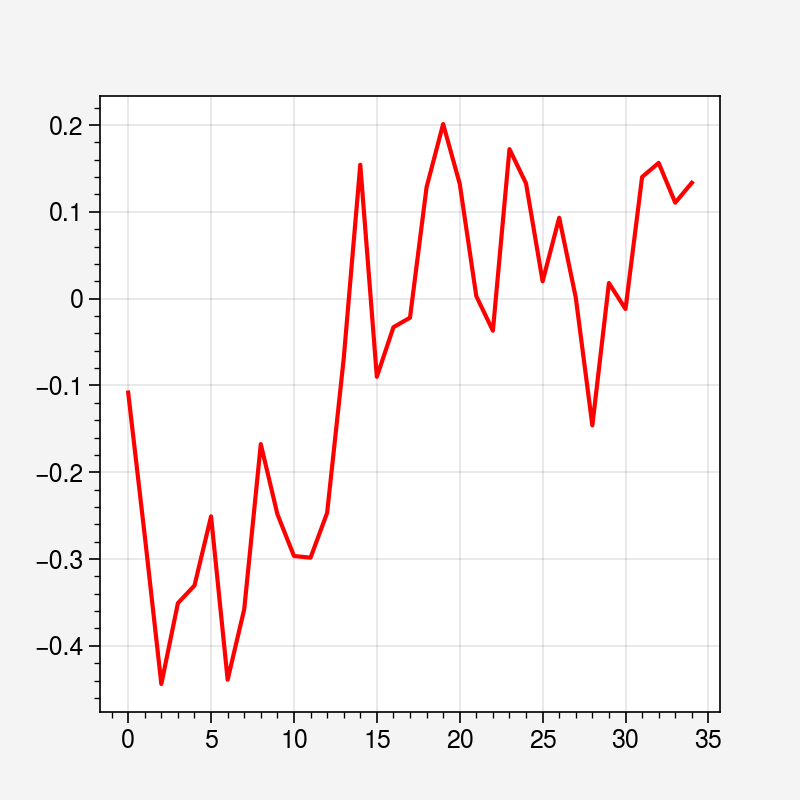

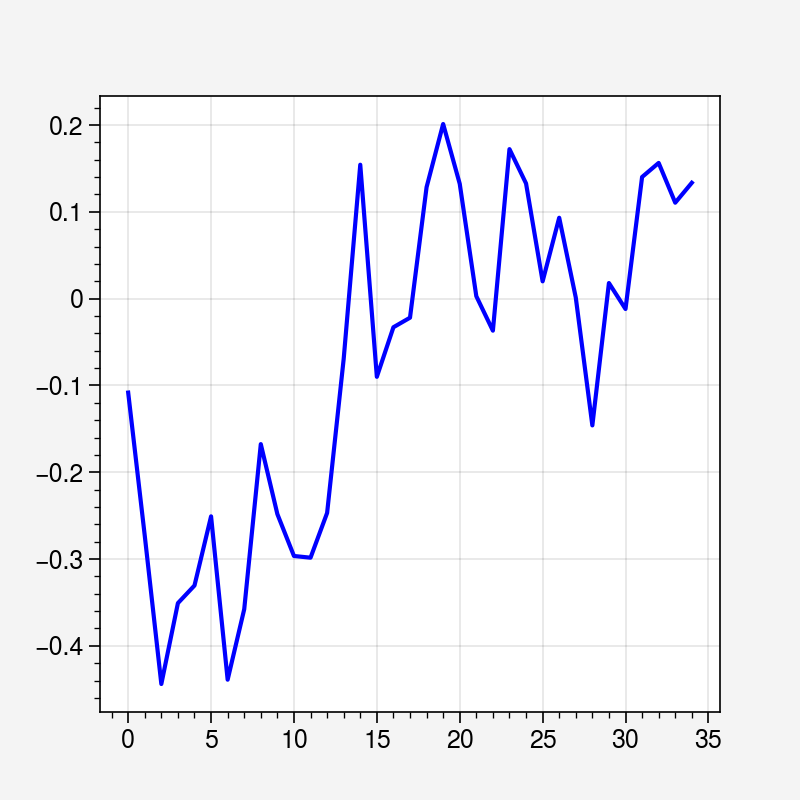

In [69]:
plt.plot(pcc_ufs5_p67, c = 'red')
plt.plot(pcc_ufs6_p67, c = 'blue')
plt.show()

#### Calculate amplitude metric

In [ ]:
import math
def amplitude_metric(timelag,rmm_list_ERA,rmm_list_model,modeldata,eraidata,lat_min,lat_max,lon_min,lon_max):
    nn=len(rmm_list_ERA[0,:])
    amp=np.empty( ( len (timelag),nn) ,dtype=float)
    for inumber in range (len(rmm_list_ERA[0,:])):
        for itime in range (len (timelag)):
            model_z500_temp=modeldata [ rmm_list_model[inumber], itime, : , : ]
            erai_anomaly_temp=eraidata [ rmm_list_ERA[itime,inumber], : , : ]
            x=erai_anomaly_temp.sel(lat=slice(lat_max,lat_min),lon=slice(lon_min,lon_max))
            y=model_z500_temp.sel(latitude=slice(lat_max,lat_min),longitude=slice(lon_min,lon_max))
            x_stacked=x.stack(grid=('lat','lon'))
            y_stacked=y.stack(grid=('latitude','longitude'))
            model_z500_variance_temp=np.var(y_stacked)
            erai_anomaly_variance_temp=np.var(x_stacked)
            amp[itime,inumber]=math.sqrt(model_z500_variance_temp/erai_anomaly_variance_temp)
    return amp

In [ ]:
## Prototype 5 amplitude metric
amp_ufs5_p23 = amplitude_metric(timelag,rmm_list_1_ERA_23,rmm_list_model_23,model_anomaly_ufs5,erai_anomaly,lat_min,lat_max,lon_min,lon_max)
amp_ufs5_p67 = amplitude_metric(timelag,rmm_list_ERA_67,rmm_list_model_67,model_anomaly_ufs5,erai_anomaly,lat_min,lat_max,lon_min,lon_max)       
amp_ufs5_p23=np.mean ( amp_ufs5_p23,axis= 1   )
amp_ufs5_p67=np.mean ( amp_ufs5_p67,axis= 1   )

## Prototype 6 amplitude metric
amp_ufs6_p23 = amplitude_metric(timelag,rmm_list_ERA_23,rmm_list_model_23,model_anomaly_ufs6,erai_anomaly,lat_min,lat_max,lon_min,lon_max)
amp_ufs6_p67 = amplitude_metric(timelag,rmm_list_ERA_67,rmm_list_model_67,model_anomaly_ufs6,erai_anomaly,lat_min,lat_max,lon_min,lon_max)       
amp_ufs6_p23=np.mean ( amp_ufs6_p23,axis= 1   )
amp_ufs6_p67=np.mean ( amp_ufs6_p67,axis= 1   )

In [ ]:
plt.plot(amp_ufs5_p23, c = 'red')
plt.plot(amp_ufs6_p23, c = 'blue')
plt.show()